# Compare the GM-SEUS products (arrays & individual panels) to the existing collected dataproducts (USPVDB, CCPV, SAM, OSM, and OSM/CCPV panel shapes )  

For GMSEUS "Big Panel" paper with Jacob Stid (stidjaco@msu.edu)  
Work in this notebook from Jeremy Rapp (rappjer1@gmail.com) 

In [1]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Polygon comparison

In [ ]:
# load the panel polygons for comparison
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')

# get only gmseus arrays where Source == 'gmseus'
# gmseus_arrays = gmseus_arrays[gmseus_arrays['Source'] == 'gmseus']

# print the first few rows of the data
print(gmseus_arrays.head())
print(gmseus_arrays.shape)
print('GMSEUS arrays attributes')
print(gmseus_arrays.area.describe())

# get only gmseus arrays where Source == 'gmseus'

# create a subset of the data 10 rows long
gmseus_arrays_subset = gmseus_arrays.head(1)

# plot the subset of the data
gmseus_arrays_subset.plot()
plt.show()


In [ ]:
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
#print(uspvdb_arrays.head())


# print the first few rows of the data
print(uspvdb_arrays.head())
print(uspvdb_arrays.shape)
print('USPVDB arrays attributes')
print(uspvdb_arrays.area.describe())


# Explode the geometries
# exploded_uspvdb = explode_geometries(uspvdb_arrays)

# # Print the first few rows of the exploded data
# print(exploded_uspvdb.head())

# # Get the first few rows of the exploded data
# exploded_uspvdb_subset = exploded_uspvdb.head(1)

# # Plot the exploded data
# exploded_uspvdb_subset.plot()
# plt.show()

In [ ]:
import geopandas as gpd

# Load the GMSEUS arrays and fix geometries
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')
gmseus_arrays['geometry'] = gmseus_arrays.buffer(0)

# check if any gmseus arrays overlap
gmseus_self_overlap = gmseus_arrays.geometry.apply(lambda g: not g.is_valid)

if gmseus_self_overlap.any():
    print("Some GMSEUS geometries self-overlap or are invalid.")
    invalid_geometries = gmseus_arrays[gmseus_self_overlap]
    print(f"Number of invalid geometries: {len(invalid_geometries)}")
else:
    print("All GMSEUS geometries are valid and do not self-overlap.")

# Load USPVDB arrays and fix geometries
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
uspvdb_arrays['geometry'] = uspvdb_arrays.buffer(0)

# Ensure CRS consistency
if gmseus_arrays.crs != uspvdb_arrays.crs:
    uspvdb_arrays = uspvdb_arrays.to_crs(gmseus_arrays.crs)

# Add explicit IDs to preserve original indices
gmseus_arrays = gmseus_arrays.reset_index().rename(columns={'index': 'gmseus_id'})
uspvdb_arrays = uspvdb_arrays.reset_index().rename(columns={'index': 'uspvdb_id'})

# Perform spatial join to identify intersections
intersections = gpd.sjoin(uspvdb_arrays, gmseus_arrays, how="inner", predicate="intersects")

# Group USPVDB geometries by GMSEUS ID and union them
unioned_uspvdb = (
    intersections.groupby('gmseus_id')['geometry']
    .apply(lambda g: g.unary_union)  # Union the full original USPVDB geometries
    .reset_index()
)

# Merge unioned geometries back into the original USPVDB dataset
updated_uspvdb = uspvdb_arrays.copy()
updated_uspvdb = updated_uspvdb.merge(
    unioned_uspvdb, how='left', left_on='uspvdb_id', right_on='gmseus_id', suffixes=('', '_unioned')
)

# Replace geometry in USPVDB with unioned geometry where applicable
updated_uspvdb['geometry'] = updated_uspvdb['geometry_unioned'].combine_first(updated_uspvdb['geometry'])
updated_uspvdb = updated_uspvdb.drop(columns=['geometry_unioned', 'gmseus_id'])



In [50]:
# Step 1: Load and Fix Geometries
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')

# Ensure valid geometries
gmseus_arrays['geometry'] = gmseus_arrays.buffer(0)
uspvdb_arrays['geometry'] = uspvdb_arrays.buffer(0)

# Ensure CRS consistency
if gmseus_arrays.crs != uspvdb_arrays.crs:
    uspvdb_arrays = uspvdb_arrays.to_crs(gmseus_arrays.crs)



# Step 2: Explode USPVDB to Handle Large Areas
uspvdb_exploded = uspvdb_arrays.explode(index_parts=True).reset_index()
print(f"USPVDB Exploded Geometries: {len(uspvdb_exploded)} rows")

# Step 2.5: Explode GMSEUS to Handle Large Areas
gmseus_exploded = gmseus_arrays.explode(index_parts=True).reset_index()
print(f"GMSEUS Exploded Geometries: {len(gmseus_exploded)} rows")

# gmseus_exploded = gmseus_arrays

# Step 3: Simplify USPVDB Geometries
# intersections = gpd.sjoin(uspvdb_exploded, gmseus_exploded, how="inner", predicate="intersects")
simplified_uspvdb = (
    uspvdb_exploded.dissolve()  # Use union_all if unary_union is deprecated
    .reset_index()
)


# Debugging: Check Simplified USPVDB Geometries
# print("Simplified USPVDB Columns:", simplified_uspvdb_gdf.columns)

# Step 4: Simplify GMSEUS Geometries Based on Simplified USPVDB
# # Perform spatial join between GMSEUS and Simplified USPVDB
# gmseus_intersections = gpd.sjoin(gmseus_exploded, simplified_uspvdb_gdf, how="inner", predicate="intersects")

# # Debugging: Print the columns of the resulting spatial join
# print("Columns in gmseus_intersections:", gmseus_intersections.columns)

# # Check for the correct column for USPVDB IDs
# if 'gmseus_id_left' in gmseus_intersections.columns:
#     gmseus_intersections['uspvdb_id'] = gmseus_intersections['gmseus_id_left']
# elif 'gmseus_id_right' in gmseus_intersections.columns:
#     gmseus_intersections['uspvdb_id'] = gmseus_intersections['gmseus_id_right']
# else:
#     raise KeyError("uspvdb_id is missing in gmseus_intersections!")

# Group by USPVDB ID to union GMSEUS geometries intersecting each USPVDB geometry
simplified_gmseus = (
    gmseus_exploded.dissolve('subArrID')  # Use union_all if necessary
    .reset_index()
)
# drop all columns containing the word 'level'
simplified_gmseus = simplified_gmseus.loc[:, ~simplified_gmseus.columns.str.contains('^level_')]
simplified_uspvdb = simplified_uspvdb.loc[:, ~simplified_uspvdb.columns.str.contains('^level_')]

# Explode simplified GMSEUS geometries to ensure one-to-one mapping
# simplified_gmseus = simplified_gmseus.explode(index_parts=False).reset_index()

# Explode simplified USPVDB geometries to ensure one-to-one mapping
simplified_uspvdb = simplified_uspvdb.explode(index_parts=False).reset_index()

simplified_gmseus = simplified_gmseus.loc[:, ~simplified_gmseus.columns.str.contains('^level_')]
simplified_uspvdb = simplified_uspvdb.loc[:, ~simplified_uspvdb.columns.str.contains('^level_')]

# Add explicit IDs
simplified_gmseus = simplified_gmseus.reset_index().rename(columns={'index': 'gmseus_id'})
simplified_uspvdb = simplified_uspvdb.reset_index().rename(columns={'index': 'uspvdb_id'})

# Convert to GeoDataFrame and ensure CRS is preserved
simplified_gmseus_gdf = gpd.GeoDataFrame(simplified_gmseus, geometry='geometry', crs=gmseus_arrays.crs)

simplified_uspvdb_gdf = gpd.GeoDataFrame(simplified_uspvdb, geometry='geometry', crs=uspvdb_arrays.crs)

# Debugging: Check Simplified GMSEUS Geometries
print("Simplified GMSEUS Columns:", simplified_gmseus_gdf.columns)
print("Simplified uspvdb Columns:", simplified_uspvdb_gdf.columns)

# Generate simplfiei USPVDB GeoDataFrame
simplified_uspvdb_gdf = gpd.GeoDataFrame(simplified_uspvdb, geometry='geometry', crs=uspvdb_arrays.crs)

# Step 6: Add Area Calculations
simplified_gmseus_gdf['area_a'] = simplified_gmseus_gdf.geometry.area
simplified_uspvdb_gdf['area_b'] = simplified_uspvdb_gdf.geometry.area

# Step 5: Ensure One-to-One Mapping for Final Intersections
final_intersections = gpd.sjoin(simplified_gmseus_gdf, simplified_uspvdb_gdf, how="inner", predicate="intersects")

# Debugging: Print the columns in the final_intersections
print("Columns in final_intersections:", final_intersections.columns)

# Step 6: Add Area Calculations
final_intersections['intersection_area'] = final_intersections.geometry.area

# Step 7: Merge Area Attributes for Calculations
# final_intersections = final_intersections.merge(
#     simplified_gmseus_gdf[['uspvdb_id', 'area_a']], on='uspvdb_id', how='left'
# )
# final_intersections = final_intersections.merge(
#     simplified_uspvdb_gdf[['gmseus_id', 'area_b']], on='gmseus_id', how='left'
# )

# Step 8: Calculate Metrics (Jaccard and GOF)
final_intersections['union_area'] = (
    final_intersections['area_a'] + final_intersections['area_b'] - final_intersections['intersection_area']
)
final_intersections['jaccard_index'] = final_intersections['intersection_area'] / final_intersections['union_area']
final_intersections['insideness'] = final_intersections['intersection_area'] / final_intersections['area_b']
final_intersections['weight'] = final_intersections['intersection_area'] / final_intersections['area_a']
final_intersections['gof'] = final_intersections['insideness'] * final_intersections['weight']


# Step 8.5 Keep weird intersections where jaccard > 1
weird_intersections = final_intersections[final_intersections['jaccard_index'] > 1]
# Save weird intersections
weird_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\weird_intersections.shp')

# Step 9: Trim Final Intersections to Valid Metrics
final_intersections = final_intersections[
    (final_intersections['gof'] >= 0) & (final_intersections['gof'] <= 1) &
    (final_intersections['jaccard_index'] >= 0) & (final_intersections['jaccard_index'] <= 1)
]

# Step 10: Summarize Metrics
overall_gof = final_intersections['gof'].mean()
average_jaccard = final_intersections['jaccard_index'].mean()
median_gof = final_intersections['gof'].median()
median_jaccard = final_intersections['jaccard_index'].median()

# # Save results
# simplified_uspvdb_gdf.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_simplified_union_new.shp')
# simplified_gmseus_gdf.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\gmseus_simplified_union_new.shp')
# final_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\final_intersections_with_metrics_new.shp')

# Store the 

# Print summary
print(f"Overall GOF: {overall_gof}")
print(f"Average Jaccard Index: {average_jaccard}")
print(f"Median GOF: {median_gof}")
print(f"Median Jaccard Index: {median_jaccard}")

# Return Data for Plotting
final_results = {
    "intersections_gdf": final_intersections,
    "overall_gof": overall_gof,
    "average_jaccard": average_jaccard,
    "simplified_uspvdb_gdf": simplified_uspvdb_gdf,
    "simplified_gmseus_gdf": simplified_gmseus_gdf,
}


USPVDB Exploded Geometries: 9890 rows
GMSEUS Exploded Geometries: 16437 rows
Simplified GMSEUS Columns: Index(['gmseus_id', 'subArrID', 'geometry', 'arrayID', 'nativeID', 'Source',
       'pnlNum', 'area', 'mount', 'azimuth', 'lengthRati', 'shortEdge',
       'longEdge', 'QAQC', 'perimeter', 'PmArRatio', 'compactnes', 'areaRatio',
       'numPanels', 'pnlArea', 'arrayArea'],
      dtype='object')
Simplified uspvdb Columns: Index(['level_0', 'uspvdb_id', 'nativeID', 'instYr', 'cap_mw', 'area',
       'modType', 'AVtype', 'azimuth', 'mount', 'Source', 'geometry'],
      dtype='object')
Columns in final_intersections: Index(['gmseus_id', 'subArrID', 'geometry', 'arrayID', 'nativeID_left',
       'Source_left', 'pnlNum', 'area_left', 'mount_left', 'azimuth_left',
       'lengthRati', 'shortEdge', 'longEdge', 'QAQC', 'perimeter', 'PmArRatio',
       'compactnes', 'areaRatio', 'numPanels', 'pnlArea', 'arrayArea',
       'area_a', 'index_right', 'level_0', 'uspvdb_id', 'nativeID_right',
     

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\4000062736.py:119: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  weird_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\weird_intersections.shp')
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'nativeID_left' to 'nativeID_l'
  ogr_write(
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Source_left' to 'Source_lef'
  ogr_write(
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'azimuth_left' to 'azimuth_le'
  ogr_write(
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'nativeID_rig

In [ ]:
# Export final_intersections where jaccard is greater than 1
final_intersections_filter = final_intersections[final_intersections['jaccard_index'] > 1]
final_intersections_filter.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\final_intersections_filter.shp')

In [ ]:
# Average size of exploded geometries
# print(gmseus_arrays.shape)
# print('GMSEUS arrays attributes')
# print(gmseus_arrays.area.describe())
# print(' ')
print(uspvdb_arrays.shape)
print('USPVDB arrays attributes')
print(uspvdb_arrays.area.describe())
print(' ')
print(updated_uspvdb.shape)
print('updated USPVDB arrays attributes')
print(updated_uspvdb.area.describe())

In [ ]:
# Average size of exploded geometries
print(gmseus_arrays.shape)
print('GMSEUS arrays attributes')
print(gmseus_arrays.area.describe())
print(' ')
print(updated_uspvdb.shape)
print('USPVDB arrays attributes')
print(updated_uspvdb.area.describe())

In [114]:
# # Print information about the exploded data
# print(gmseus_arrays.shape)
# print(uspvdb_arrays.shape)
# print(exploded_gmseus.shape)
# print(exploded_uspvdb.shape)

# # Average size of exploded geometries
# print(exploded_gmseus.shape)
# print('GMSEUS exploded arrays attributes')
# print(exploded_gmseus.area.describe())
# print(' ')
# print(exploded_uspvdb.shape)
# print('USPVDB exploded arrays attributes')
# print(exploded_uspvdb.area.describe())

In [ ]:
def calculate_gof_and_jaccard_vectorized(map1, map2):
    """
    Calculate Goodness-of-Fit (GOF) and Jaccard Index for intersections between two maps using vectorized operations.
    
    Parameters:
        map1 (GeoDataFrame): First map with polygons to be compared.
        map2 (GeoDataFrame): Second map with polygons serving as the reference.
        
    Returns:
        intersections_gdf (GeoDataFrame): GeoDataFrame with intersections, Jaccard, and GOF scores.
        overall_gof (float): Overall GOF score for map1.
        average_jaccard (float): Average Jaccard Index for all intersections.
    """
    # Explode geometries for both maps
    # map1 = map1.explode(index_parts=True).reset_index(drop=True)
    # map2 = map2.explode(index_parts=True).reset_index(drop=True)

    # Ensure CRS match
    if map1.crs != map2.crs:
        map2 = map2.to_crs(map1.crs)
    
    # Add an explicit ID column to keep track of original indices
    map1['id_a'] = map1.index
    map2['id_b'] = map2.index

    # Perform spatial intersection to get intersected geometries
    intersections = gpd.overlay(map1, map2, how="intersection")

    # Add areas for map1, map2, and intersections
    map1['area_a'] = map1.geometry.area
    map2['area_b'] = map2.geometry.area
    intersections['intersection_area'] = intersections.geometry.area

    # Merge area attributes using explicit IDs
    intersections = intersections.merge(
        map1[['id_a', 'area_a']],
        on='id_a',
        how='left'
    )
    intersections = intersections.merge(
        map2[['id_b', 'area_b']],
        on='id_b',
        how='left'
    )

    # Calculate Jaccard Index
    intersections['union_area'] = intersections['area_a'] + intersections['area_b'] - intersections['intersection_area']
    intersections['jaccard_index'] = intersections['intersection_area'] / intersections['union_area']

    # Calculate GOF
    intersections['insideness'] = intersections['intersection_area'] / intersections['area_b']
    intersections['weight'] = intersections['intersection_area'] / intersections['area_a']
    intersections['gof'] = intersections['insideness'] * intersections['weight']
    
    # Calculate overall metrics
    overall_gof = intersections.groupby('id_a')['gof'].sum().mean()
    average_jaccard = intersections['jaccard_index'].mean()

    return intersections, overall_gof, average_jaccard


# Example usage
map1 = gmseus_arrays
map1['geometry'] = map1.buffer(0)
print(map1.is_valid.all())

map2 = updated_uspvdb
map2['geometry'] = map2.buffer(0)
print(map2.is_valid.all())  # Should now return True

# Calculate GOF and Jaccard
intersections_gdf, overall_gof, average_jaccard = calculate_gof_and_jaccard_vectorized(map1, map2)


In [116]:
def count_intersections_and_list_polygons(jaccard_df):
    # Group by id_a to analyze intersections for each polygon in dataset A
    grouped_by_a = jaccard_df.groupby('id_a').agg(
        num_intersections=('id_b', 'count'),  # Count the number of intersections
        unique_polygons=('id_b', lambda x: list(x.unique()))  # List unique IDs of polygons
    ).reset_index()

    # Group by id_b to analyze intersections for each polygon in dataset B
    grouped_by_b = jaccard_df.groupby('id_b').agg(
        num_intersections=('id_a', 'count'),
        unique_polygons=('id_a', lambda x: list(x.unique()))
    ).reset_index()

    return grouped_by_a, grouped_by_b

# Example usage
grouped_by_a, grouped_by_b = count_intersections_and_list_polygons(intersections_gdf)

In [ ]:
# only keep the polygons that have more than 1 intersection
grouped_by_a_filtered = grouped_by_a[grouped_by_a['num_intersections'] > 1]
grouped_by_b_filtered = grouped_by_b[grouped_by_b['num_intersections'] > 1]

# Plot the distribution of the number of intersections for each polygon in dataset A
plt.figure(figsize=(10, 6))
sns.histplot(grouped_by_a_filtered['num_intersections'], bins=20, kde=False)
plt.xlabel('Number of Intersections')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Intersections for GMSEUS Arrays, circa 1/7/2025, non-exploded')
plt.show()

# Plot the distribution of the number of intersections for each polygon in dataset B
plt.figure(figsize=(10, 6))
sns.histplot(grouped_by_b_filtered['num_intersections'], bins=20, kde=False)
plt.xlabel('Number of Intersections')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Intersections for USPVDB Arrays, circa 1/7/2025, non-exploded')
plt.show()

In [ ]:
print(map1.crs)
print(map2.crs)

print(map1.is_valid.all())
print(map2.is_valid.all())

print(map1.total_bounds)  # [minx, miny, maxx, maxy]
print(map2.total_bounds)

In [ ]:
import seaborn as sns

# Print overall GOF and average Jaccard Index
print("Overall GOF:", overall_gof)
print("Average Jaccard Index:", average_jaccard)

# Plot the histogram of GOF scores
plt.figure(figsize=(10, 6))
sns.histplot(intersections_gdf['gof'], bins=20, kde=False)
plt.xlabel('Goodness-of-Fit (GOF)')
plt.ylabel('Frequency')
plt.title('Histogram of Goodness-of-Fit (GOF) Scores')
plt.show()

# Plot the histogram of Jaccard Index values
plt.figure(figsize=(10, 6))
sns.histplot(intersections_gdf['jaccard_index'], bins=20, kde=False)
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Index Values')
plt.show()

In [ ]:


def scatter_with_log_marginals(intersections_gdf, metric, title="Log-Transformed Scatter Plot with Marginal Distributions", area_threshold = 45):
    """
    Scatter plot with log-transformed marginal distributions for areas and color-coded by a given metric.
    
    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing intersection data with areas and metrics.
        metric (str): The metric to visualize on the scatter plot ("jaccard_index" or "gof").
        title (str): Title for the plot.
    """
    if metric not in intersections_gdf.columns:
        raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")
    # filter out small areas
    intersections_gdf = intersections_gdf[(intersections_gdf['area_a'] > area_threshold) & (intersections_gdf['area_b'] > area_threshold)]

    # Apply log transformation to the area columns
    intersections_gdf['log_area_a'] = np.log10(intersections_gdf['area_a'])
    intersections_gdf['log_area_b'] = np.log10(intersections_gdf['area_b'])
    
    # Set up the grid
    g = sns.JointGrid(data=intersections_gdf, x="log_area_a", y="log_area_b", space=0, height=8)
    
    # Scatter plot in the center
    g.plot_joint(
        sns.scatterplot,
        hue=intersections_gdf[metric],
        palette='viridis',
        alpha=0.7
    )
    
    # KDE plots on the margins
    g.plot_marginals(sns.kdeplot, fill=True, alpha=0.5)
    
    # Customize color bar for the selected metric
    norm = plt.Normalize(intersections_gdf[metric].min(), intersections_gdf[metric].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = g.fig.colorbar(sm, ax=g.ax_joint, orientation="vertical", label=f"{metric.capitalize()} Value")
    
    # Set labels and title
    g.set_axis_labels("Log10(Area GMSEUS)", "Log10(Area USPVDB)")
    g.fig.suptitle(title, y=1.02)
    
    # Add a count of the number of points in the lower-left of the plot
    g.ax_joint.text(
        0.05, 0.05, f'N = {intersections_gdf.shape[0]}, Area Threshold = {area_threshold}',
        horizontalalignment='left', verticalalignment='bottom',
        transform=g.ax_joint.transAxes,
        fontsize=12, bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.show()

# Example usage:
# Scatter plot with Jaccard Index
scatter_with_log_marginals(intersections_gdf, metric="jaccard_index", title="Jaccard Index Scatter with Log Marginals, olddataset 12/11/2025")

# Scatter plot with GOF
scatter_with_log_marginals(intersections_gdf, metric="gof", title="GOF Scatter with Log Marginals, olddataset 12/11/2025")


In [121]:


def plot_intersections_with_metric(intersections, boundary_data, metric, map_label, metric_value):
    """
    Plot intersection points with a specified metric (Jaccard or GOF) as a color scale,
    overlaid on a boundary map using x and y coordinates for point locations.
    
    Parameters:
        intersections (GeoDataFrame): GeoDataFrame of intersections with calculated metrics.
        boundary_data (GeoDataFrame): GeoDataFrame representing the boundary (e.g., lower 48 states).
        metric (str): The metric to visualize ("jaccard_index" or "gof").
        map_label (str): Label for the map to use in titles and annotations.
    """
    # Ensure CRS match between intersections and boundary_data
    if intersections.crs != boundary_data.crs:
        boundary_data = boundary_data.to_crs(intersections.crs)

    # Check if the provided metric exists in the intersections GeoDataFrame
    if metric not in intersections.columns:
        raise ValueError(f"Metric '{metric}' not found in the intersections GeoDataFrame.")

    # Extract x and y coordinates for intersections
    intersections['x'] = intersections.geometry.centroid.x
    intersections['y'] = intersections.geometry.centroid.y

    # Create a plot
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot the boundary
    boundary_data.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
    
    # Plot the intersection points with the metric as the color
    scatter = ax.scatter(
        intersections['x'], intersections['y'],
        c=intersections[metric],
        cmap='viridis',
        s=10,
        alpha=0.8,
        label="Intersections"
    )
    
    # Add a colorbar for the metric
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label(f"{metric.capitalize()} Value")

    # Title and labels
    ax.set_title(f"{map_label} Intersections Colored by {metric.capitalize()}")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

        # Add a count of intersections as a text label
    intersection_count = len(intersections)
    ax.text(
        0.02, 0.98, f"Number of Intersections: {intersection_count}, {metric.capitalize()} Value: {metric_value}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.grid(False)
    plt.legend()

    plt.show()

In [ ]:
# set a float to 3 decimal places
overall_gof_rounded = round(overall_gof, 3)
average_jaccard_rounded = round(average_jaccard, 3)

# plot these plots as a subplot

# Plot intersections colored by Jaccard Index
plot_intersections_with_metric(intersections_gdf, us_boundary, "jaccard_index", "Non-exploded new GMSEUS and updated USPVDB, circa 1/9/2025", average_jaccard_rounded)

# Plot intersections colored by GOF
plot_intersections_with_metric(intersections_gdf, us_boundary, "gof", "Non-exploded new GMSEUS and updated USPVDB, circa 1/9/2025", overall_gof_rounded)

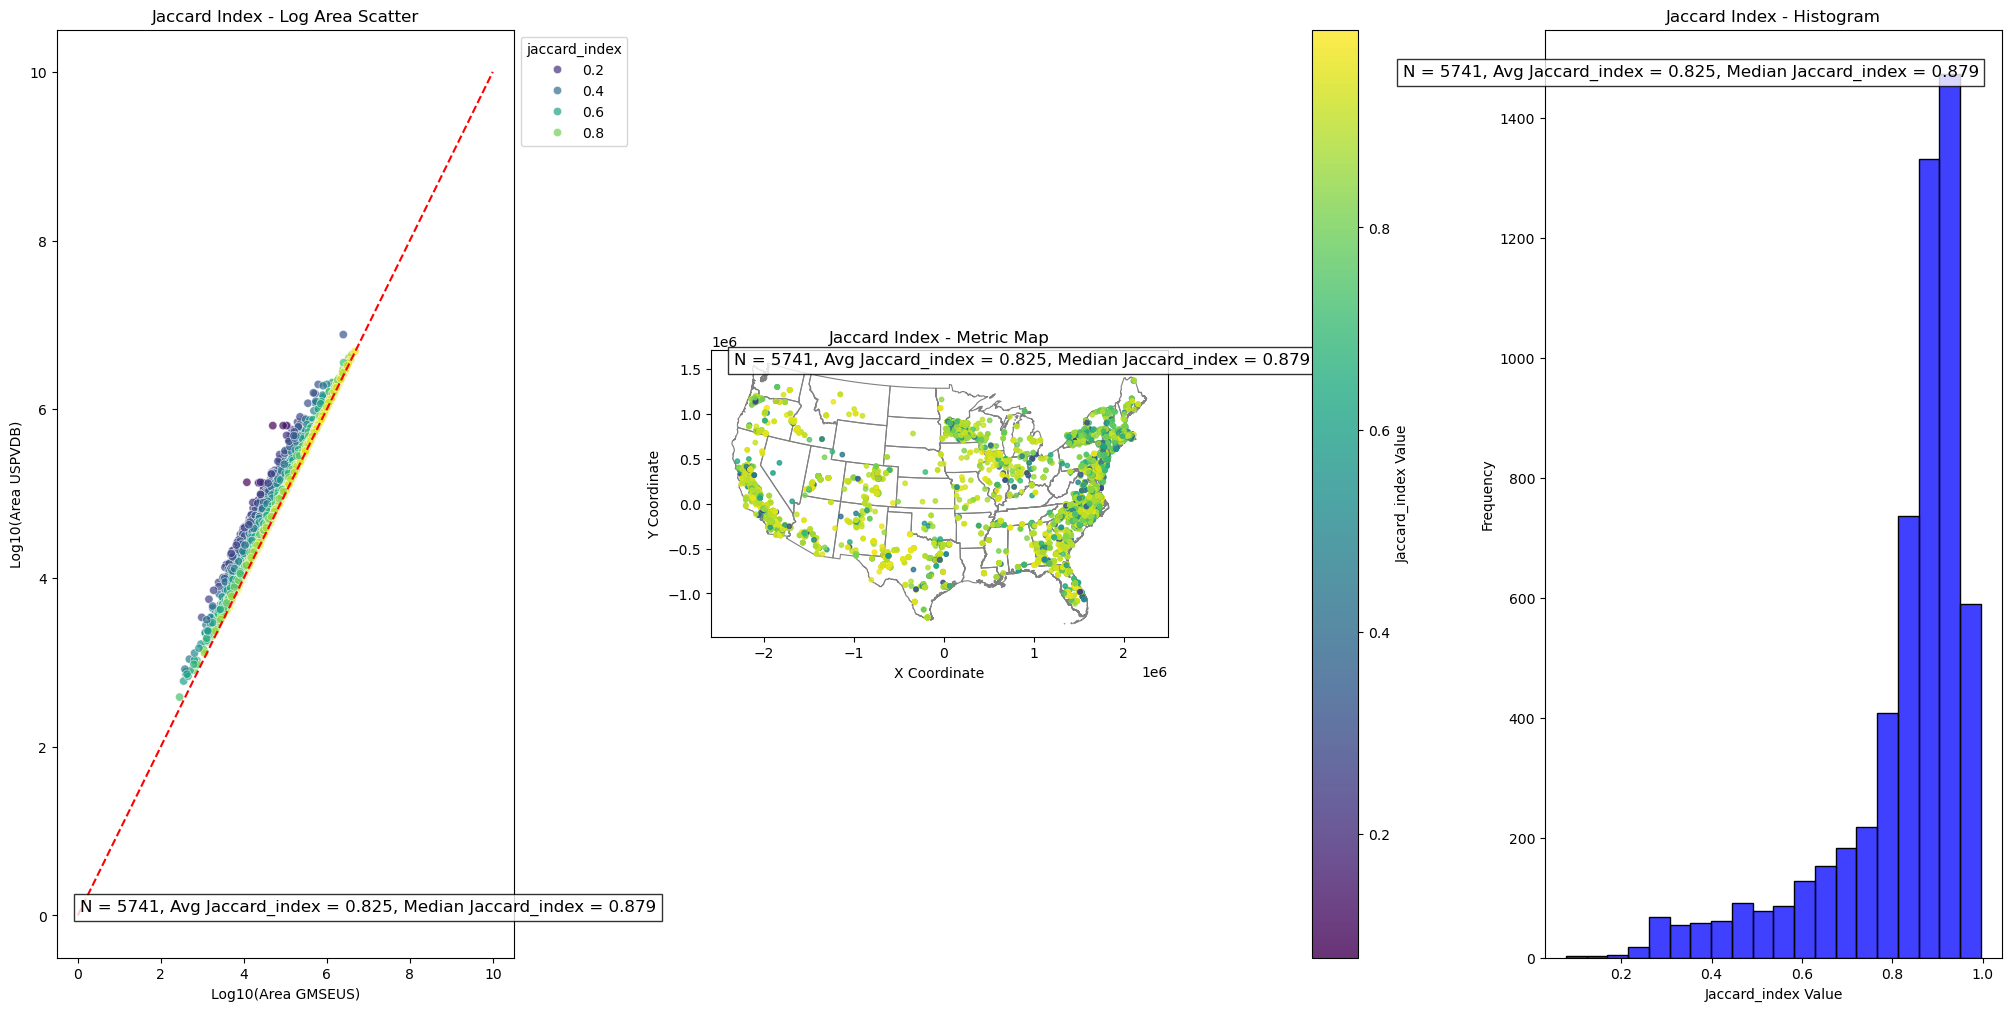

In [5]:
def plot_metric_pairs_with_details(intersections_gdf, boundary_data, metrics, titles, average_values, area_threshold=45):
    """
    Create a subplot grid where each row represents a pair of plots for a single metric:
    - Left: Log-transformed scatter plot of areas showing the metric.
    - Middle: Spatial map of the metric values.
    - Right: Histogram of the metric values.
    - Includes rounded average and median values and the count of intersections.
    
    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing intersections and metric values.
        boundary_data (GeoDataFrame): GeoDataFrame representing the boundary map.
        metrics (list of str): List of metrics to visualize (e.g., ["jaccard_index", "gof"]).
        titles (list of str): Titles for each metric row, corresponding to the metrics.
        average_values (list of tuple): A list of tuples containing (average, median) for each metric.
        area_threshold (float): Threshold to filter out small areas from the dataset.
    """
    # Determine the number of rows (metrics)
    num_metrics = len(metrics)
    
    # Create a subplot grid
    fig, axes = plt.subplots(num_metrics, 3, figsize=(20, 10 * num_metrics), constrained_layout=True)
    # If there’s only one metric, axes will be 1D, so we wrap it for consistency
    if num_metrics == 1:
        axes = [axes]
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        # Filter intersections based on area threshold
        filtered_gdf = intersections_gdf[
            (intersections_gdf['area_a'] > area_threshold) & (intersections_gdf['area_b'] > area_threshold)
        ]
        
        # Check if metric exists
        if metric not in filtered_gdf.columns:
            raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")

        # Scatter plot with log-transformed areas
        filtered_gdf['log_area_a'] = np.log10(filtered_gdf['area_a'])
        filtered_gdf['log_area_b'] = np.log10(filtered_gdf['area_b'])
        
        scatter_ax = axes[i][0]
        sns.scatterplot(
            data=filtered_gdf,
            x="log_area_a",
            y="log_area_b",
            hue=metric,
            palette="viridis",
            alpha=0.7,
            ax=scatter_ax
        )
        scatter_ax.set_title(f"{title} - Log Area Scatter")
        scatter_ax.set_xlabel("Log10(Area GMSEUS)")
        scatter_ax.set_ylabel("Log10(Area USPVDB)")
        # add 1 to 1 line
        scatter_ax.plot([0, 10], [0, 10], color='red', linestyle='--')
        scatter_ax.legend(title=metric, bbox_to_anchor=(1, 1), loc='upper left')
        scatter_ax.text(
            0.05, 0.05,
            f"N = {len(filtered_gdf)}, Avg {metric.capitalize()} = {average_values[i][0]}, Median {metric.capitalize()} = {average_values[i][1]}",
            transform=scatter_ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        # Map of metric values
        map_ax = axes[i][1]
        boundary_data.plot(ax=map_ax, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
        filtered_gdf['x'] = filtered_gdf.geometry.centroid.x
        filtered_gdf['y'] = filtered_gdf.geometry.centroid.y
        scatter = map_ax.scatter(
            filtered_gdf['x'],
            filtered_gdf['y'],
            c=filtered_gdf[metric],
            cmap="viridis",
            s=10,
            alpha=0.8
        )
        cbar = plt.colorbar(scatter, ax=map_ax, orientation='vertical')
        cbar.set_label(f"{metric.capitalize()} Value")
        map_ax.set_title(f"{title} - Metric Map")
        map_ax.set_xlabel("X Coordinate")
        map_ax.set_ylabel("Y Coordinate")
        map_ax.grid(False)
        map_ax.text(
            0.05, 0.95,
            f"N = {len(filtered_gdf)}, Avg {metric.capitalize()} = {average_values[i][0]}, Median {metric.capitalize()} = {average_values[i][1]}",
            transform=map_ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        # Histogram of metric values
        hist_ax = axes[i][2]
        sns.histplot(filtered_gdf[metric], bins=20, kde=False, ax=hist_ax, color="blue")
        hist_ax.set_title(f"{title} - Histogram")
        hist_ax.set_xlabel(f"{metric.capitalize()} Value")
        hist_ax.set_ylabel("Frequency")
        hist_ax.text(
            0.95, 0.95,
            f"N = {len(filtered_gdf)}, Avg {metric.capitalize()} = {average_values[i][0]}, Median {metric.capitalize()} = {average_values[i][1]}",
            transform=hist_ax.transAxes,
            fontsize=12,
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    plt.show()

# Boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(final_intersections.crs)

# Example usage
metrics = ["jaccard_index"]
titles = ["Jaccard Index"]
average_values = [
    (round(average_jaccard, 3), round(median_jaccard, 3))]

# # Count unique USPVDB geometries in intersections
# unique_uspvdb_ids = intersections['uspvdb_id'].nunique()
# print(f"Unique USPVDB geometries in intersections: {unique_uspvdb_ids}")

# # Total rows in intersections
# total_intersections = len(intersections)
# print(f"Total intersections: {total_intersections}")

# # Total geometries in updated USPVDB
# total_uspvdb_geometries = len(updated_uspvdb)
# print(f"Total geometries in updated USPVDB: {total_uspvdb_geometries}")

# # Ensure each USPVDB geometry is counted once per GMSEUS
# unique_intersections = intersections[['uspvdb_id', 'gmseus_id']].drop_duplicates()

# # Count total intersections
# total_unique_intersections = len(unique_intersections)
# print(f"Total unique intersections: {total_unique_intersections}")

# multiple_gmseus_per_uspvdb = intersections.groupby('uspvdb_id').size()
# print(f"Number of USPVDB geometries intersecting multiple GMSEUS geometries: {(multiple_gmseus_per_uspvdb > 1).sum()}")

# usp_intersections_summary = intersections.groupby('uspvdb_id')['gmseus_id'].nunique()
# usp_intersections_summary.name = 'num_gmseus_intersections'
# print(usp_intersections_summary.describe())

# # Add intersection area to intersections GeoDataFrame
# intersections['intersection_area'] = intersections.geometry.area

# # For each USPVDB geometry, retain the GMSEUS geometry with the largest intersection area
# largest_intersection = (
#     intersections.sort_values(by='intersection_area', ascending=False)
#     .drop_duplicates(subset='uspvdb_id')
# )

# print(f"Number of unique USPVDB geometries after simplifying: {len(largest_intersection)}")

# gmseus_grouped_unions = (
#     intersections.groupby('uspvdb_id')['geometry']
#     .apply(lambda g: g.unary_union)
#     .reset_index()
# )
# print(f"Number of unioned geometries: {len(gmseus_grouped_unions)}")

# Plot metric pairs with details

# trim to include only where jaccard or gof is less than or equal to 1
# final_intersections_sub = final_intersections[(final_intersections['jaccard_index'] <= 1) & (final_intersections['gof'] <= 1)]

plot_metric_pairs_with_details(final_intersections, us_boundary, metrics, titles, average_values)


g:\Code\Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\1011868751.py:67: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


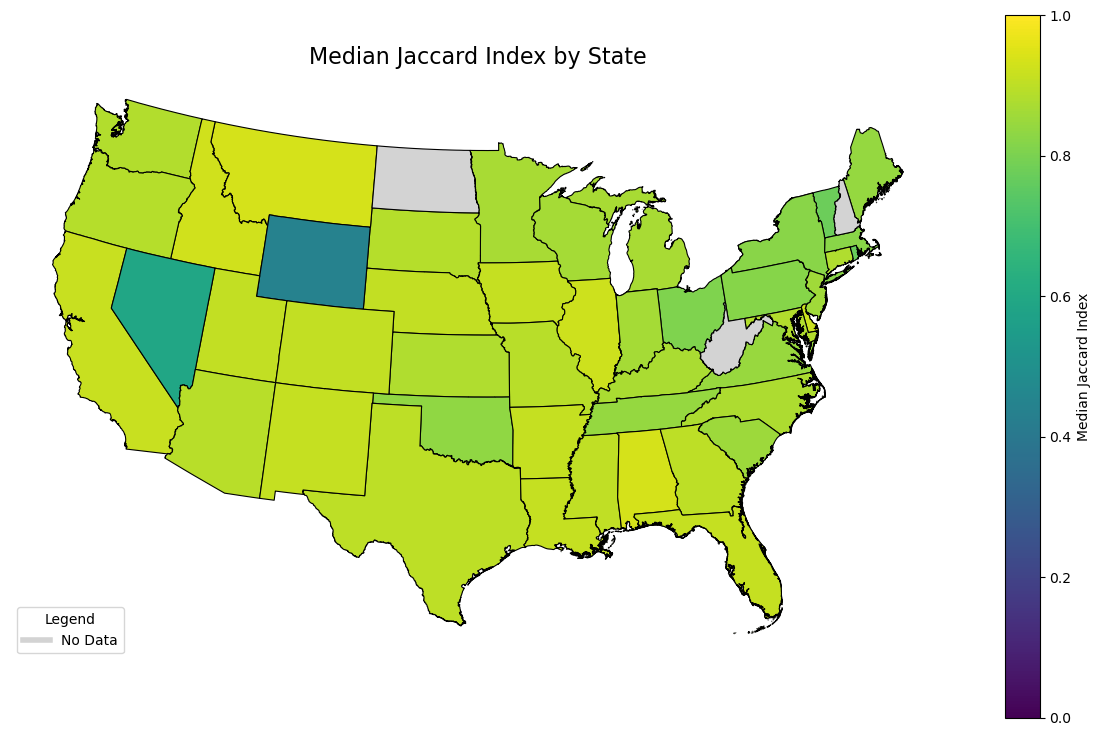

In [52]:
# Making the state level maps where the median jaccard value is reported for each state

# Load the US state boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(final_intersections.crs)


# Step 2: Assign state names to intersections based on their location
def find_state_name(geom, boundary):
    """Find the state name containing the geometry."""
    containing_states = boundary.loc[boundary.contains(geom), "STATE"]
    if not containing_states.empty:
        return containing_states.values[0]
    return None  # Return None if no state contains the geometry

# Apply the function to find state names
final_intersections['state_name'] = final_intersections.geometry.apply(lambda x: find_state_name(x, us_boundary))

# Step 3: Filter out intersections without a valid state name
final_intersections = final_intersections[final_intersections['state_name'].notna()]

# Step 4: Group by state name and calculate the median Jaccard Index for each state
state_median_jaccard = (
    final_intersections.groupby('state_name', as_index=False)['jaccard_index']
    .median()
    .rename(columns={'jaccard_index': 'median_jaccard'})
)

# Step 5: Merge median Jaccard values with US boundary data
us_boundary = us_boundary.merge(state_median_jaccard, left_on='STATE', right_on='state_name', how='left')

# Step 6: Add a "No Data" flag for states without data
us_boundary['has_data'] = ~us_boundary['median_jaccard'].isna()  # True if state has data, False otherwise

# Step 7: Plot the map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot states with data using the color palette
states_with_data = us_boundary[us_boundary['has_data']]
states_with_data.plot(
    ax=ax,
    column='median_jaccard',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.8,
    legend=True,
    legend_kwds={
        'label': "Median Jaccard Index",
        'shrink': 0.6,
        'orientation': "vertical",
    },
    vmin=0,  # Set color range min
    vmax=1   # Set color range max
)

# Plot states without data in light gray
states_without_data = us_boundary[~us_boundary['has_data']]
states_without_data.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='black',
    linewidth=0.8,
    label="No Data"
)

# Add a manual "No Data" legend
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color="lightgrey", lw=4))
labels.append("No Data")
ax.legend(handles, labels, loc="lower left", title="Legend", fontsize=10)

# Add title and adjust
ax.set_title("Median Jaccard Index by State", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()





Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\2589010274.py:65: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


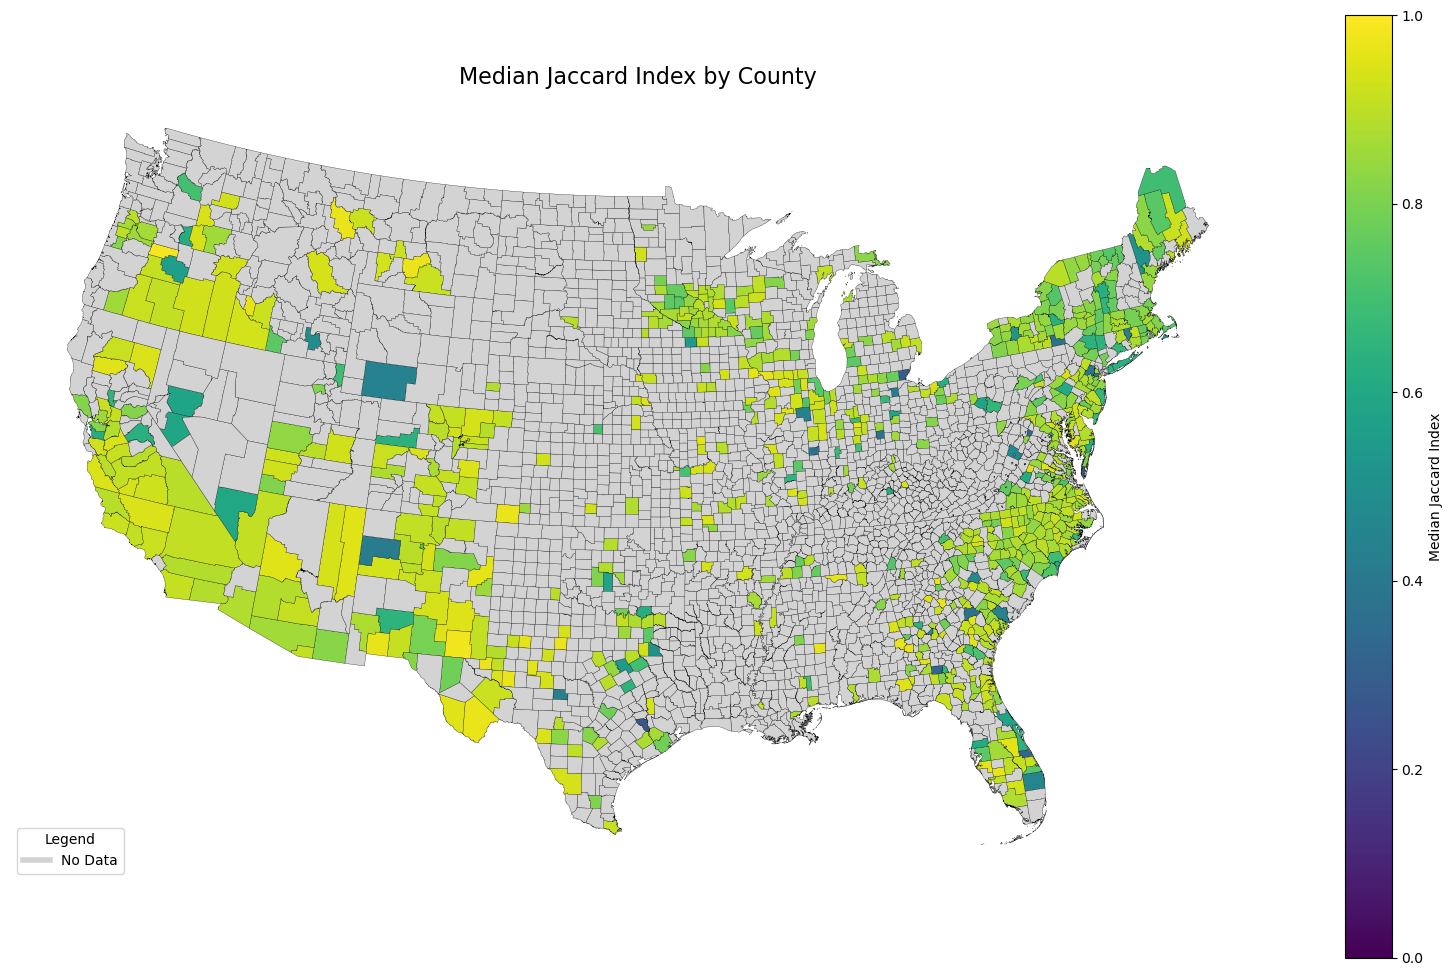

In [54]:
# Step 1: Load the US county boundary data
counties = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\counties_nolakes.shp")
counties = counties.to_crs(final_intersections.crs)

print(counties.columns)
# Step 2: Assign county names to intersections based on their location
def find_county_name(geom, boundary):
    """Find the county containing the geometry."""
    containing_counties = boundary.loc[boundary.contains(geom), "GEOID"]
    if not containing_counties.empty:
        return containing_counties.values[0]
    return None  # Return None if no county contains the geometry

# Apply the function to find county names
final_intersections['county_name'] = final_intersections.geometry.apply(lambda x: find_county_name(x, counties))

# Step 3: Filter out intersections without a valid county name
final_intersections = final_intersections[final_intersections['county_name'].notna()]

# Step 4: Group by county name and calculate the median Jaccard Index for each county
county_median_jaccard = (
    final_intersections.groupby('county_name', as_index=False)['jaccard_index']
    .median()
    .rename(columns={'jaccard_index': 'median_jaccard'})
)

# Step 5: Merge median Jaccard values with county boundary data
counties = counties.merge(county_median_jaccard, left_on='GEOID', right_on='county_name', how='left')

# Step 6: Add a "No Data" flag for counties without data
counties['has_data'] = ~counties['median_jaccard'].isna()  # True if county has data, False otherwise

# Step 7: Plot the map
fig, ax = plt.subplots(figsize=(16, 16))

# Plot counties with data using the color palette
counties_with_data = counties[counties['has_data']]
counties_with_data.plot(
    ax=ax,
    column='median_jaccard',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.2,
    legend=True,
    legend_kwds={
        'label': "Median Jaccard Index",
        'shrink': 0.6,
        'orientation': "vertical",
    },
    vmin=0,  # Set color range min
    vmax=1   # Set color range max
)

# Plot counties without data in light gray
counties_without_data = counties[~counties['has_data']]
counties_without_data.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='black',
    linewidth=0.2,
    label="No Data"
)

# Add a manual "No Data" legend
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color="lightgrey", lw=4))
labels.append("No Data")
ax.legend(handles, labels, loc="lower left", title="Legend", fontsize=10)

# Add title and adjust
ax.set_title("Median Jaccard Index by County", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

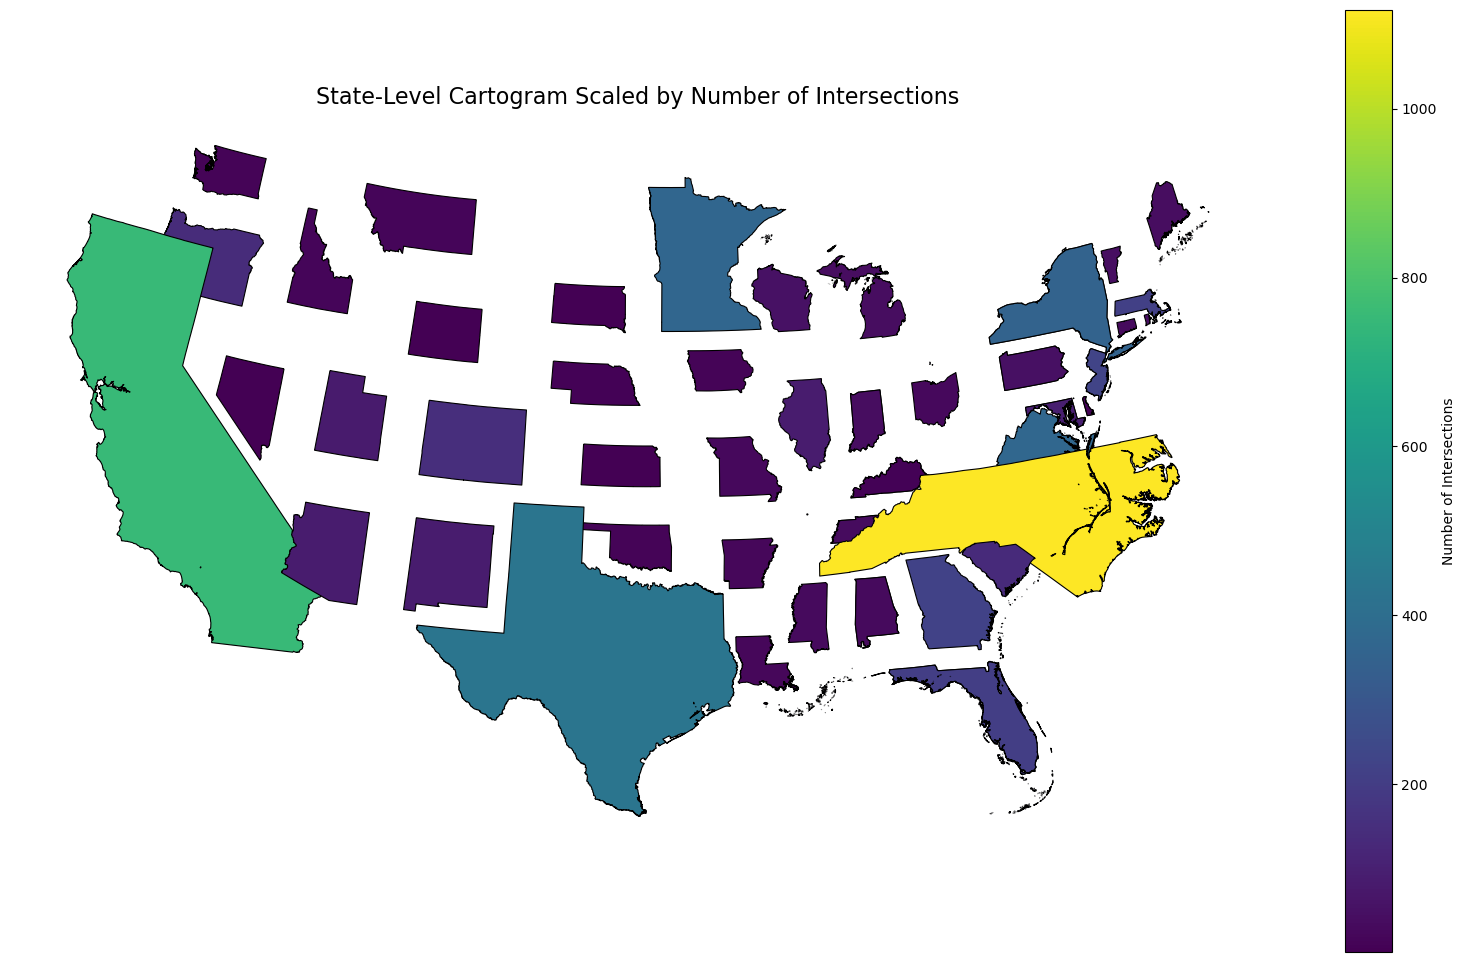

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.affinity import scale  # Import scale for scaling geometries

# Step 1: Load the US state boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(final_intersections.crs)

# Step 2: Assign state names to intersections based on their location
def find_state_name(geom, boundary):
    """Find the state name containing the geometry."""
    containing_states = boundary.loc[boundary.contains(geom), "STATE"]
    if not containing_states.empty:
        return containing_states.values[0]
    return None  # Return None if no state contains the geometry

# Apply the function to find state names
final_intersections['state_name'] = final_intersections.geometry.apply(lambda x: find_state_name(x, us_boundary))

# Step 3: Count intersections per state
state_intersection_counts = final_intersections.groupby('state_name').size().reset_index(name='intersection_count')

# Step 4: Merge intersection counts with state boundaries
# Drop the existing `state_name` column from us_boundary if it exists to avoid duplicates
if 'state_name' in us_boundary.columns:
    us_boundary = us_boundary.drop(columns=['state_name'])

us_boundary = us_boundary.merge(state_intersection_counts, left_on='STATE', right_on='state_name', how='left')

# Step 5: Scale geometries by intersection count
# Normalize the intersection count for scaling (e.g., between 0.5 and 2)
max_count = us_boundary['intersection_count'].max()
min_count = us_boundary['intersection_count'].min()
us_boundary['scaling_factor'] = us_boundary['intersection_count'].fillna(0).apply(
    lambda x: 0.5 + 1.5 * (x - min_count) / (max_count - min_count) if x > 0 else 0.5
)

# Apply scaling to each state's geometry
def scale_geometry(row):
    if row['scaling_factor'] > 0:
        centroid = row['geometry'].centroid
        return scale(row['geometry'], xfact=row['scaling_factor'], yfact=row['scaling_factor'], origin=centroid)
    return row['geometry']

us_boundary['scaled_geometry'] = us_boundary.apply(scale_geometry, axis=1)

# Step 6: Plot the cartogram
fig, ax = plt.subplots(figsize=(16, 16))

# Plot scaled geometries
us_boundary = gpd.GeoDataFrame(us_boundary, geometry='scaled_geometry')
us_boundary.plot(
    ax=ax,
    column='intersection_count',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.8,
    legend=True,
    legend_kwds={'label': "Number of Intersections", 'shrink': 0.6},
)

# Add title and remove axes
ax.set_title("State-Level Cartogram Scaled by Number of Intersections", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def plot_boxplot_metrics(intersections_gdf, metrics, title="Boxplot of Metrics"):
    """
    Create a boxplot for the given metrics in the GeoDataFrame.

    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing the metrics to visualize.
        metrics (list of str): List of metrics to include in the boxplot (e.g., ["jaccard_index", "gof"]).
        title (str): Title for the boxplot.
    """
    # Check if metrics exist in the GeoDataFrame
    for metric in metrics:
        if metric not in intersections_gdf.columns:
            raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")
    
    # Prepare data for boxplot
    boxplot_data = intersections_gdf[metrics].melt(var_name="Metric", value_name="Value")
    
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Metric", y="Value", data=boxplot_data, palette="viridis")
    
    # Add title and labels
    plt.title(title)
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()

# Example usage
metrics = ["jaccard_index", "gof"]
plot_boxplot_metrics(final_intersections_sub, metrics, title="Boxplot of Jaccard Index and GOF Metrics")

In [ ]:


invalid_jaccard = final_intersections[final_intersections['jaccard_index'] > 1]

# invalid_gof = final_intersections[final_intersections['gof'] > 1]

print(f"Number of invalid Jaccard Index shapes: {len(invalid_jaccard)}")
# print(f"Number of invalid GOF shapes: {len(invalid_gof)}")
# Function to plot invalid shapes along with their corresponding GMSEUS and USPVDB geometries
def plot_invalid_shapes_with_context(invalid_gdf, gmseus_gdf, uspvdb_gdf, metric, title, num_to_plot=5):
    """
    Plots invalid shapes one by one with context from GMSEUS and USPVDB geometries.
    
    Parameters:
    - invalid_gdf: GeoDataFrame of invalid geometries.
    - gmseus_gdf: GeoDataFrame of GMSEUS geometries.
    - uspvdb_gdf: GeoDataFrame of USPVDB geometries.
    - metric: Metric name ("Jaccard Index" or "GOF").
    - title: Title of the plot.
    - num_to_plot: Number of shapes to plot individually.
    """
    count = min(num_to_plot, len(invalid_gdf))
    for i, (_, row) in enumerate(invalid_gdf.iterrows()):
        if i >= count:
            break
        
        # Extract the specific geometry and its ID
        invalid_geometry = row.geometry
        usp_id = row['uspvdb_id'] if 'uspvdb_id' in row else None
        gms_id = row['gmseus_id'] if 'gmseus_id' in row else None
        
        # Filter GMSEUS and USPVDB geometries that intersect the invalid geometry
        gmseus_context = gmseus_gdf[gmseus_gdf.intersects(invalid_geometry)]
        uspvdb_context = uspvdb_gdf[uspvdb_gdf.intersects(invalid_geometry)]
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 8))
        uspvdb_context.plot(ax=ax, color='blue', edgecolor='black', alpha=0.3, label='USPVDB Context')
        gmseus_context.plot(ax=ax, color='green', edgecolor='black', alpha=0.3, label='GMSEUS Context')
        gpd.GeoSeries([invalid_geometry]).plot(ax=ax, color='red', edgecolor='black', alpha=0.3, label='Invalid Shape')
        
        ax.set_title(f"{title} - {metric} > 1\nShape {i+1}/{count}")
        ax.legend()
        plt.show()

# Plot invalid Jaccard Index shapes with context
if not invalid_jaccard.empty:
    print("Plotting invalid Jaccard Index shapes with context:")
    plot_invalid_shapes_with_context(invalid_jaccard, simplified_gmseus_gdf, simplified_uspvdb_gdf, 
                                     "Jaccard Index", "Invalid Shapes", num_to_plot=14)

# # Plot invalid GOF shapes with context
# if not invalid_gof.empty:
#     print("Plotting invalid GOF shapes with context:")
#     plot_invalid_shapes_with_context(invalid_gof, gmseus_arrays, uspvdb_arrays, 
#                                      "GOF", "Invalid Shapes", num_to_plot=5)



### Individual panel comparisons

PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]
PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","42

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


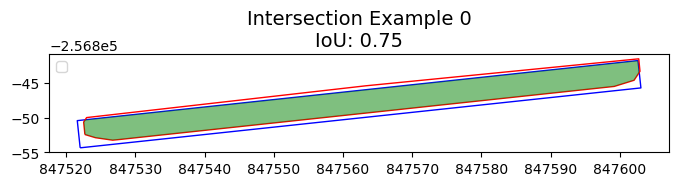

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


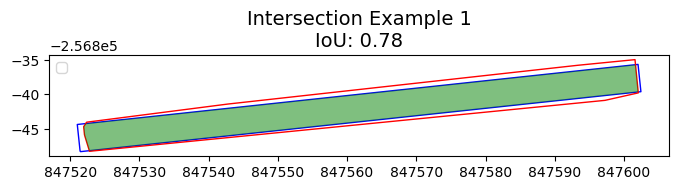

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


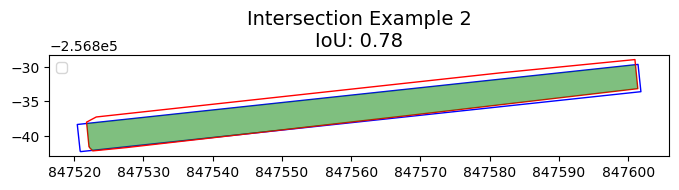

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


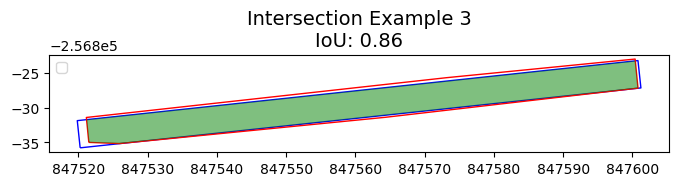

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


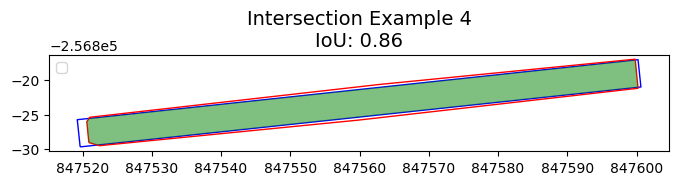

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


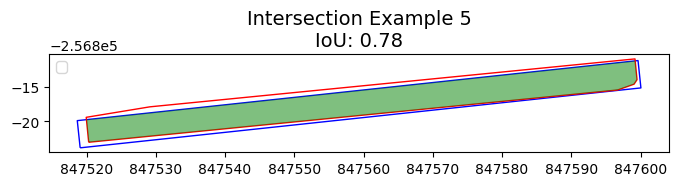

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


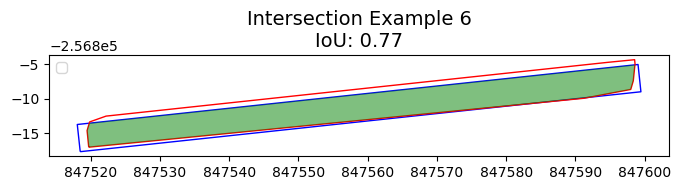

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


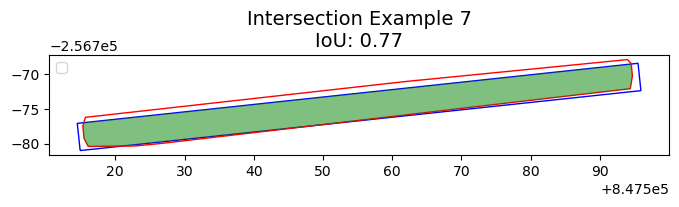

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


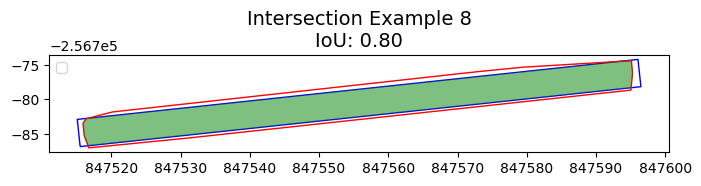

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\994827080.py:62: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


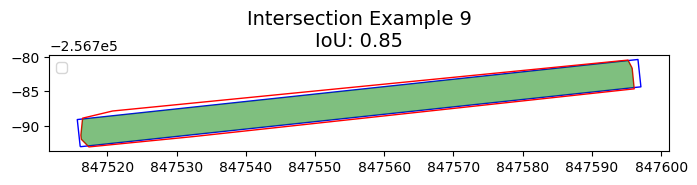

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Load the datasets
existing_panels = gpd.read_file("G:\\Data\\GMSEUS\\intermediateProducts\\existingDatasetPanelShapes.shp")
gmseus_panels = gpd.read_file("G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Panels.shp")

# Step 2: Ensure geometries are valid and CRS matches
existing_panels['geometry'] = existing_panels.buffer(0)
gmseus_panels['geometry'] = gmseus_panels.buffer(0)

if existing_panels.crs != gmseus_panels.crs:
    gmseus_panels = gmseus_panels.to_crs(existing_panels.crs)

# Step 3: Perform spatial join to get candidate pairs
candidates = gpd.sjoin(existing_panels, gmseus_panels, how="inner", predicate="intersects")

# Step 4: Reset index to avoid duplicate labels and align geometries
candidates = candidates.reset_index(drop=True)
geom_existing = candidates["geometry"].reset_index(drop=True)
geom_gmseus = gmseus_panels.loc[candidates["index_right0"], "geometry"].reset_index(drop=True)

# Step 5: Vectorized intersection and union calculations
intersection_geom = geom_existing.intersection(geom_gmseus, align=False)
union_geom = geom_existing.union(geom_gmseus, align=False)

# Step 6: Calculate IoU for all candidate pairs
intersection_area = intersection_geom.area
union_area = union_geom.area
iou = intersection_area / union_area

# Step 7: Filter valid intersections
valid_indices = iou > 0
valid_intersections = candidates.loc[valid_indices].copy()  # Copy to avoid SettingWithCopyWarning
valid_intersections["intersection_geometry"] = intersection_geom[valid_indices].reset_index(drop=True)
valid_intersections["iou"] = iou[valid_indices].reset_index(drop=True)

# Convert to GeoDataFrame for visualization and further analysis
valid_intersections_gdf = gpd.GeoDataFrame(valid_intersections, geometry="intersection_geometry", crs=existing_panels.crs)

# Step 8: Visualize some examples
for i, row in valid_intersections_gdf.head(10).iterrows():  # Limit to 10 examples for plotting
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot the existing panel geometry
    gpd.GeoSeries([row["geometry"]]).plot(
        ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Existing Panel"
    )
    
    # Plot the corresponding GMSEUS panel geometry
    gpd.GeoSeries([gmseus_panels.loc[row["index_right0"], "geometry"]]).plot(
        ax=ax, edgecolor="red", facecolor="none", linewidth=1, label="GMSEUS Panel"
    )
    
    # Plot the intersection geometry
    gpd.GeoSeries([row["intersection_geometry"]]).plot(
        ax=ax, color="green", alpha=0.5, label="Intersection"
    )
    
    # Add title and legend
    ax.set_title(f"Intersection Example {i}\nIoU: {row['iou']:.2f}", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels
    ax.legend(by_label.values(), by_label.keys(), loc="upper left")
    
    # Show the plot
    plt.show()


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


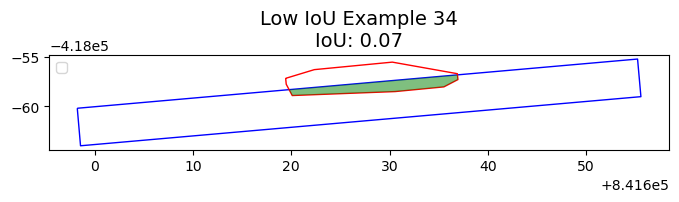

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


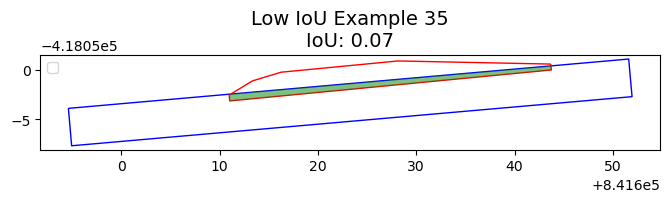

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


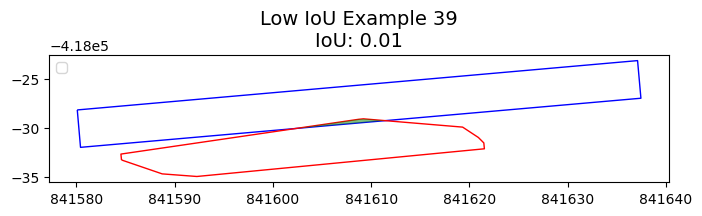

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


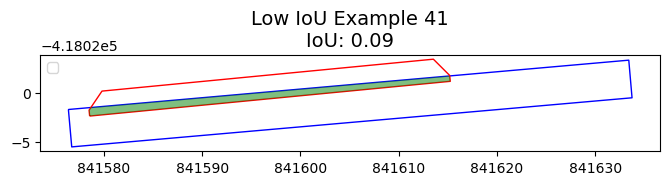

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


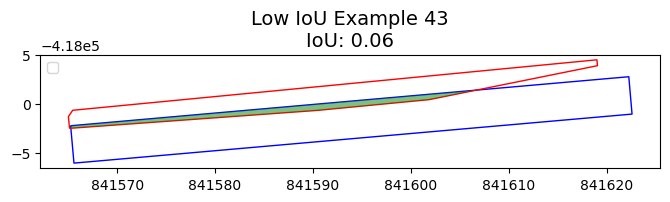

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


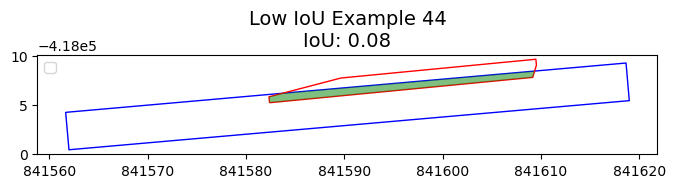

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


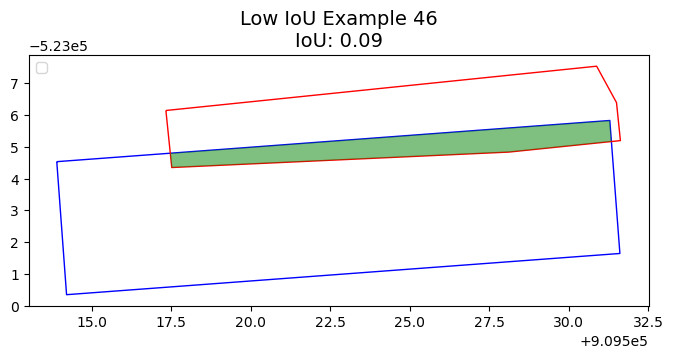

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


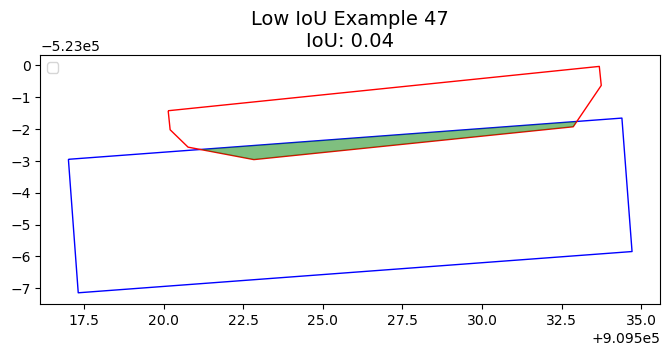

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


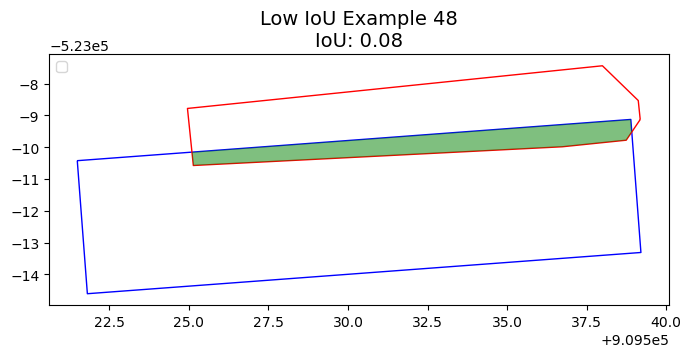

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\257406809.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


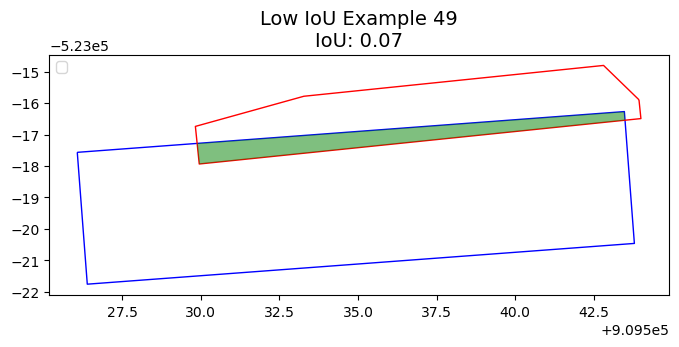

In [23]:
# Plot some examples of lower scoring intersections (low IoU)
low_iou_examples = valid_intersections_gdf[valid_intersections_gdf["iou"] < 0.1].head(10)

for i, row in low_iou_examples.iterrows():
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot the existing panel geometry
    gpd.GeoSeries([row["geometry"]]).plot(
        ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Existing Panel"
    )
    
    # Plot the corresponding GMSEUS panel geometry
    gpd.GeoSeries([gmseus_panels.loc[row["index_right0"], "geometry"]]).plot(
        ax=ax, edgecolor="red", facecolor="none", linewidth=1, label="GMSEUS Panel"
    )
    
    # Plot the intersection geometry
    gpd.GeoSeries([row["intersection_geometry"]]).plot(
        ax=ax, color="green", alpha=0.5, label="Intersection"
    )
    
    # Add title and legend
    ax.set_title(f"Low IoU Example {i}\nIoU: {row['iou']:.2f}", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels
    ax.legend(by_label.values(), by_label.keys(), loc="upper left")
    
    # Show the plot
    plt.show()


count    443200.000000
mean          0.371569
std           0.227817
min           0.030003
25%           0.182586
50%           0.329485
75%           0.552759
max           0.971172
Name: iou, dtype: object
Percentage of valid intersections: 90.17%


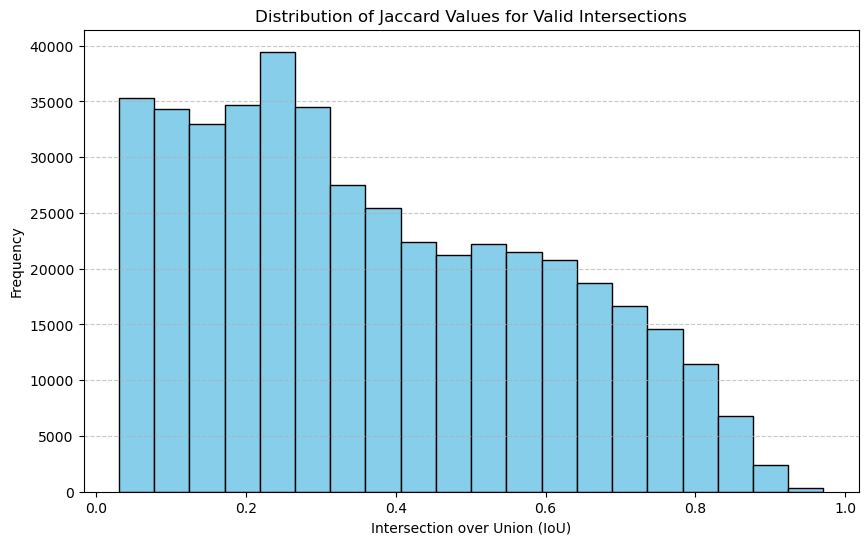

In [25]:
# print as decimals to 3 places
# calculate some statistics about the IoU values

# drop the valid_intersections that are less than 0.03 in IoU
valid_intersections_sub = valid_intersections[valid_intersections['iou'] >= 0.03]

iou_stats = valid_intersections_sub["iou"].describe().apply(lambda x: format(x, 'f'))
print(iou_stats)

# What percentage of valid intersections compared to the original dataset
percentage_valid_intersections = len(valid_intersections_sub) / len(candidates) * 100
print(f"Percentage of valid intersections: {percentage_valid_intersections:.2f}%")

# evaluate the distribution of IoU values
plt.figure(figsize=(10, 6))
plt.hist(valid_intersections_sub["iou"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Intersection over Union (IoU)")
plt.ylabel("Frequency")
plt.title("Distribution of Jaccard Values for Valid Intersections")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


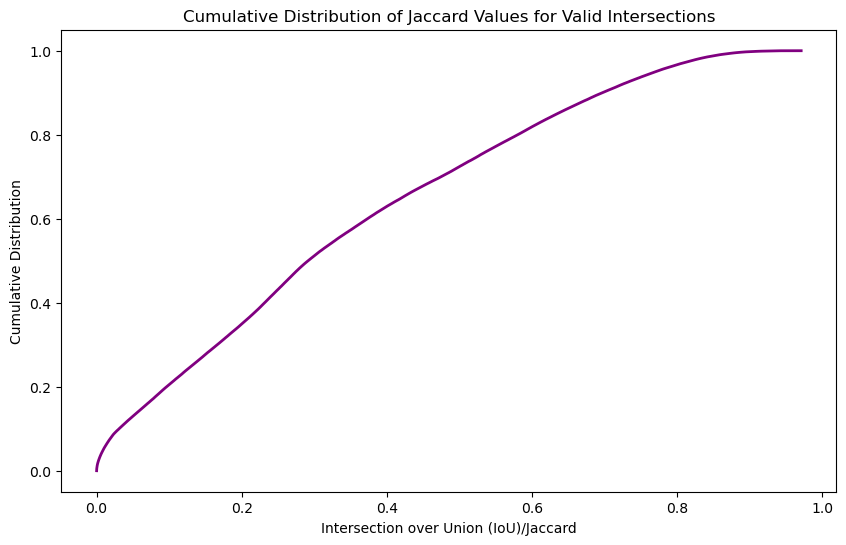

In [22]:
# plot these as a cummulatve distribution plot
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Sort the IoU values
sorted_iou = valid_intersections["iou"].sort_values()

# Step 2: Calculate the cumulative distribution
cumulative_distribution = np.linspace(0, 1, len(sorted_iou))

# Step 3: Plot the cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(sorted_iou, cumulative_distribution, color="purple", linewidth=2)
plt.xlabel("Intersection over Union (IoU)/Jaccard")
plt.ylabel("Cumulative Distribution")
plt.title("Cumulative Distribution of Jaccard Values for Valid Intersections")
plt.grid(False)
plt.show()




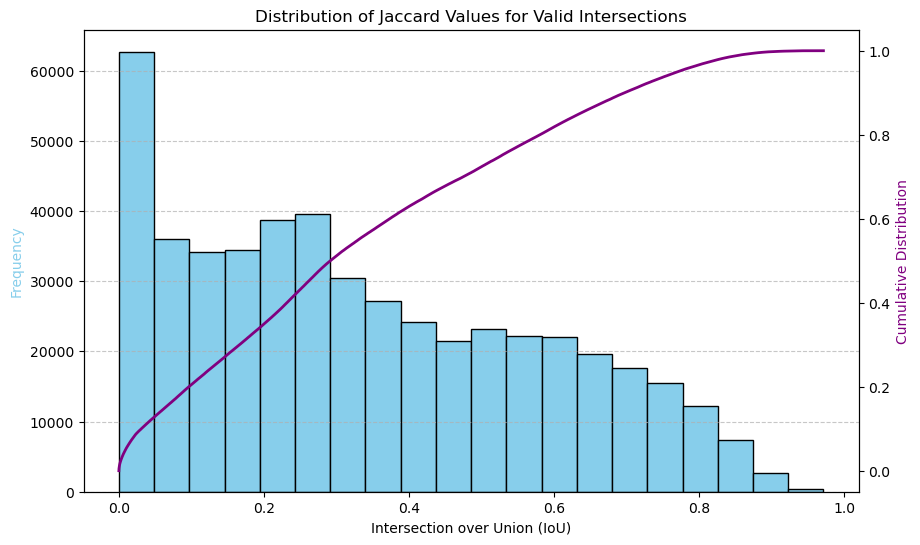

In [28]:
# make a combined plot of the histograms and the cumulative distribution using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the histogram
ax1.hist(valid_intersections["iou"], bins=20, color="skyblue", edgecolor="black")
ax1.set_xlabel("Intersection over Union (IoU)")
ax1.set_ylabel("Frequency", color="skyblue")
ax1.set_title("Distribution of Jaccard Values for Valid Intersections")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Create a second y-axis for the cumulative distribution
ax2 = ax1.twinx()
ax2.plot(sorted_iou, cumulative_distribution, color="purple", linewidth=2)
ax2.set_ylabel("Cumulative Distribution", color="purple")

# Show the plot
plt.show()






C:\Users\Jeremy\AppData\Local\Temp\ipykernel_35684\3311324549.py:65: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


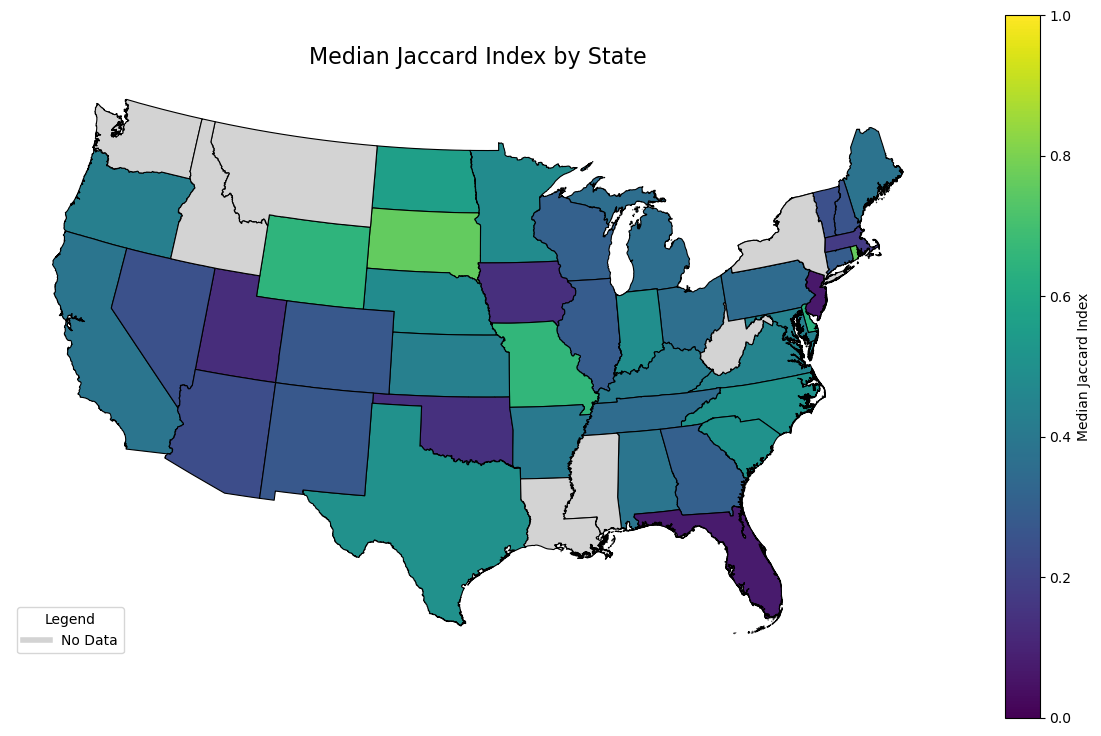

In [63]:
# Load the US state boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(valid_intersections_sub.crs)


# Step 2: Assign state names to intersections based on their location
def find_state_name(geom, boundary):
    """Find the state name containing the geometry."""
    containing_states = boundary.loc[boundary.contains(geom), "STATE"]
    if not containing_states.empty:
        return containing_states.values[0]
    return None  # Return None if no state contains the geometry

# Apply the function to find state names
valid_intersections_sub ['state_name'] = valid_intersections_sub.geometry.apply(lambda x: find_state_name(x, us_boundary))

# Step 3: Filter out intersections without a valid state name
valid_intersections_sub = valid_intersections_sub[valid_intersections_sub['state_name'].notna()]

# Step 4: Group by state name and calculate the median Jaccard Index for each state
state_median_jaccard = (
    valid_intersections_sub.groupby('state_name', as_index=False)['iou']
    .median()
    .rename(columns={'iou': 'median_jaccard'})
)

# Step 5: Merge median Jaccard values with US boundary data
us_boundary = us_boundary.merge(state_median_jaccard, left_on='STATE', right_on='state_name', how='left')

# Step 6: Add a "No Data" flag for states without data
us_boundary['has_data'] = ~us_boundary['median_jaccard'].isna()  # True if state has data, False otherwise

# Step 7: Plot the map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot states with data using the color palette
states_with_data = us_boundary[us_boundary['has_data']]
states_with_data.plot(
    ax=ax,
    column='median_jaccard',
    cmap='viridis',
    edgecolor='black',
    linewidth=0.8,
    legend=True,
    legend_kwds={
        'label': "Median Jaccard Index",
        'shrink': 0.6,
        'orientation': "vertical",
    },
    vmin=0,  # Set color range min
    vmax=1   # Set color range max
)

# Plot states without data in light gray
states_without_data = us_boundary[~us_boundary['has_data']]
states_without_data.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='black',
    linewidth=0.8,
    label="No Data"
)

# Add a manual "No Data" legend
handles, labels = ax.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color="lightgrey", lw=4))
labels.append("No Data")
ax.legend(handles, labels, loc="lower left", title="Legend", fontsize=10)

# Add title and adjust
ax.set_title("Median Jaccard Index by State", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_77992\1906542528.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


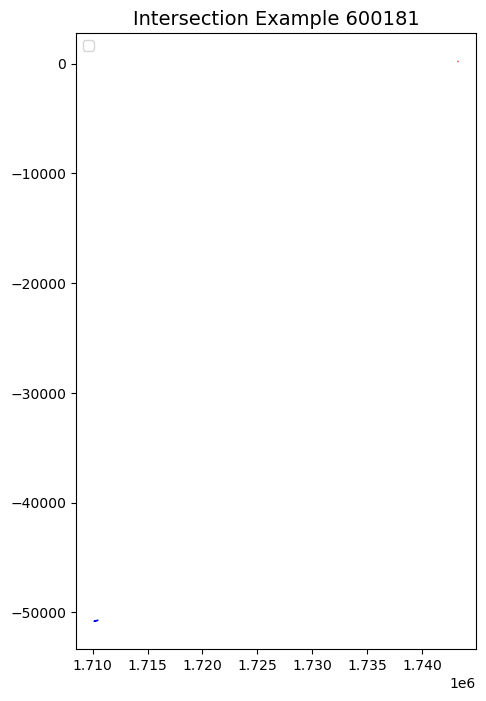

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_77992\1906542528.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


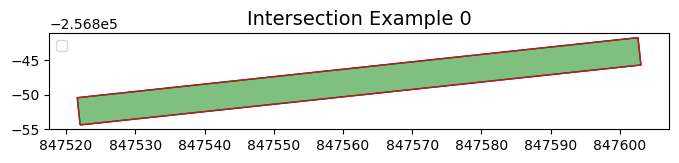

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_77992\1906542528.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


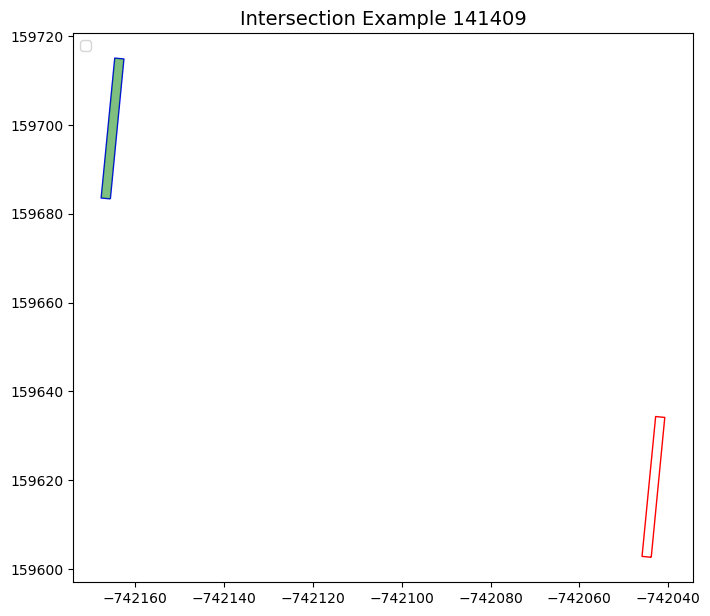

In [20]:
# Plot each intersection on a separate plot
for i, row in examples.iterrows():
    # Create a new figure for each intersection
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Plot the existing panel geometry
    gpd.GeoSeries([row["geometry"]], crs=existing_panels.crs).plot(
        ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Existing Panel"
    )
    
    # Plot the corresponding GMSEUS panel geometry
    gpd.GeoSeries([gmseus_panels.loc[row.name, "geometry"]], crs=gmseus_panels.crs).plot(
        ax=ax, edgecolor="red", facecolor="none", linewidth=1, label="GMSEUS Panel"
    )
    
    # Plot the intersection geometry
    gpd.GeoSeries([row["intersection_geometry"]], crs=existing_panels.crs).plot(
        ax=ax, color="green", alpha=0.5, label="Intersection"
    )
    
    # Add title and legend
    ax.set_title(f"Intersection Example {i}", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels
    ax.legend(by_label.values(), by_label.keys(), loc="upper left")
    
    # Show the plot
    plt.show()

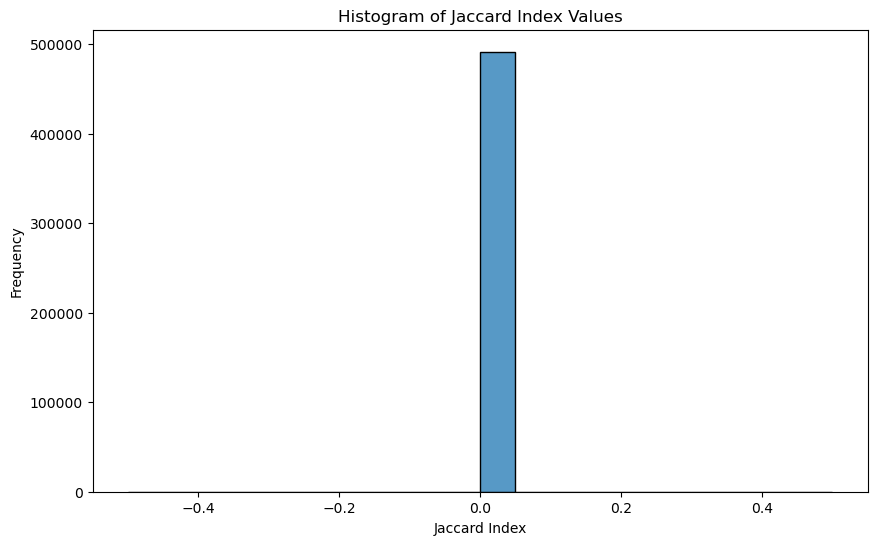

In [24]:
# Plot the histogram of Jaccard Index values
plt.figure(figsize=(10, 6))
sns.histplot(intersections['jaccard_index'], bins=20, kde=False)
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Index Values')
plt.show()


In [ ]:
# Create array shapes from panel-rows to intersect and determine "totRowArea" for each and compare.

# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')

# Call final gmseus arrays
gmseusArrays = gpd.read_file(os.path.join(derived_path, r'GMSEUS/GMSEUS_Arrays_Final.shp'))

# Call gmseus panels and existing panels
existingPanelsPath = os.path.join(derivedTemp_path, r'initialGMSEUS_Panels.shp')
gmseusPanelsNAIPPath = os.path.join(derivedTemp_path, r'GMSEUS_NAIP_Panels.shp')
#existingPanels = gpd.read_file(existingPanelsPath)
#gmseusPanels = gpd.read_file(gmseusPanelsFinalPath)

# Set variables
minPanelRowArea = 15 # square meters
panelArrayBuff = 10 # meters

# Function to check for and remove erroneous geometries in arrays
def checkArrayGeometries(arrays): 
    # For a collection of reasons, array boundaries may contain erroneous geometries that result in a near-zero area, linestrings, or points. 
    # To check for and remove these, we'll explode arrays, calculate a temporary area, remove subarrays that are less than a minimum area, then dissolve by tempID.
    arrays['tempDissolveID'] = (1 + np.arange(len(arrays)))  # Create a temporary ID for dissolving
    arrays = arrays.explode(index_parts=False)
    arrays['tempArea'] = arrays['geometry'].area
    arrays = arrays[arrays['tempArea'] >= minPanelRowArea]
    arrays = arrays.dissolve(by=['tempDissolveID'], as_index=False)
    arrays = arrays.drop(columns=['tempArea', 'tempDissolveID'])
    arrays = arrays.reset_index(drop=True)
    return arrays

# Function to create an array from a set of panel rows based on the distance between them
def createArrayFromPanels(panels, buffDist, dissolveID, areaID='area'):
 
    # Count panels per group before dissolving
    panelCounts = panels.groupby(dissolveID).size().reset_index(name='numPanels')

    # Get the total area of the panels within each group (sum of area column). 
    panelAreas = panels.groupby(dissolveID)[areaID].sum().reset_index(name='pnlArea')
    
    # Buffer the geometries by buffDist, dissovle boundaries, and unbuffer by buffDist* -1. Assign the number of objects being dissovle into a numPanels column.
    arrays = panels.copy()
    arrays['geometry'] = arrays.buffer(buffDist)
    arrays = arrays.dissolve(by=[dissolveID], as_index=False)
    arrays['geometry'] = arrays.buffer(buffDist * -1)

    # Merge the panel counts and panel areas back into the dissolved array DataFrame. Select only the dissolveID and respective columns in the right df
    arrays = arrays.merge(panelCounts[[dissolveID, 'numPanels']], on=dissolveID, how='left')
    arrays = arrays.merge(panelAreas[[dissolveID, 'pnlArea']], on=dissolveID, how='left')

    # Due to the buffering and unbuffering, some mulitpolygons contain erroneous geometries that result in a near-zero area, linestrings, or points. Remove these.
    arrays = checkArrayGeometries(arrays)

    # Reset index
    arrays = arrays.reset_index(drop=True)
    return arrays

# Just in case either panel datasets contains totRowArea or arrayID, drop it
# If column already exists in gdfs, drop them
existingPanelArrays = existingPanelArrays.drop(columns=['totRowArea'], errors='ignore')
gmseusPanels = gmseusPanels.drop(columns=['totRowArea'], errors='ignore')
existingPanels = existingPanels.drop(columns=['arrayID'], errors='ignore')
gmseusPanels = gmseusPanels.drop(columns=['arrayID'], errors='ignore')

# Also, drop area and rowArea columns from existingPanels and gmseusPanels and reset a new area column
existingPanels = existingPanels.drop(columns=['area'], errors='ignore')
gmseusPanels = gmseusPanels.drop(columns=['area'], errors='ignore')
existingPanels = existingPanels.drop(columns=['rowArea'], errors='ignore')
gmseusPanels = gmseusPanels.drop(columns=['rowArea'], errors='ignore')
existingPanels['area'] = existingPanels['geometry'].area
gmseusPanels['area'] = gmseusPanels['geometry'].area

# Spatially join gmseus arrays to panels, copy the arrayID to the panels, and drop the index columns. 
existingPanels = gpd.sjoin(existingPanels, gmseusArrays[['arrayID', 'geometry']], how='left', predicate='intersects').reset_index(drop=True)
existingPanels  = existingPanels.drop(columns=['index_left', 'index_right'], errors='ignore')
gmseusPanels = gpd.sjoin(gmseusPanels, gmseusArrays[['arrayID', 'geometry']], how='left', predicate='intersects').reset_index(drop=True)
gmseusPanels  = gmseusPanels.drop(columns=['index_left', 'index_right'], errors='ignore')

# Create solar arrays from solar panels
arrayIDcol = 'arrayID'
existingPanelArrays = createArrayFromPanels(existingPanels, panelArrayBuff, arrayIDcol)
gmseusPanelArrays = createArrayFromPanels(gmseusPanels, panelArrayBuff, arrayIDcol)

# Rename area column to rowArea
existingPanelArrays = existingPanelArrays.rename(columns={'area': 'rowArea'})
gmseusPanelArrays = gmseusPanelArrays.rename(columns={'area': 'rowArea'})

# Get totRowArea for each array from panels
totRowAreasEXISTING = existingPanelArrays.groupby('arrayID')['rowArea'].sum().reset_index(name='totRowArea')
totRowAreasGMSEUS = gmseusPanelArrays.groupby('arrayID')['rowArea'].sum().reset_index(name='totRowArea')

# Merge gmsesuArrays with the new columns by arrayID
existingPanelArrays = existingPanelArrays.merge(totRowAreasEXISTING[['arrayID', 'totRowArea']], on='arrayID', how='left')
gmseusPanelArrays = gmseusPanelArrays.merge(totRowAreasGMSEUS[['arrayID', 'totRowArea']], on='arrayID', how='left')

# Reset index
existingPanelArrays = existingPanelArrays.reset_index(drop=True)
gmseusPanelArrays = gmseusPanelArrays.reset_index(drop=True)

# This will give you two array shapefiles to compare, both with a totRowArea column, so hopefully intersecting arrays have similar totRowArea values that we can plot

# Subset both gdf for arrays where arrayID is in both gdfs
commonArrayIDlist = list(set(existingPanelArrays['arrayID']).intersection(set(gmseusPanelArrays['arrayID'])))
existingPanelArrays = existingPanelArrays[existingPanelArrays['arrayID'].isin(commonArrayIDlist)].reset_index(drop=True)
gmseusPanelArrays = gmseusPanelArrays[gmseusPanelArrays['arrayID'].isin(commonArrayIDlist)].reset_index(drop=True)

# Change name of existingPanelArrays totRowArea to totRowAreaExist
existingPanelArrays = existingPanelArrays.rename(columns={'totRowArea': 'totRowAreaExist'})

# Merge the two gdfs by arrayID
arrayComparison = gmseusPanelArrays.merge(existingPanelArrays[['arrayID', 'totRowAreaExist']], on='arrayID', how='left')

# Now, plot the two totRowArea columns against each other (log-log scale). Set alpha to 0.10
fig, ax = plt.subplots()
ax.scatter(arrayComparison['totRowArea'], arrayComparison['totRowAreaExist'], alpha=0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('GMSEUS Panel Arrays totRowArea')
ax.set_ylabel('Existing Panel Arrays totRowArea')
plt.show()